In [1]:
import lammps
import random
from tqdm import trange
import pymc3 as pm
import arviz as az
import numpy as np
import pymatgen as pmg
import theano.tensor as tt
import glob
from copy import deepcopy
import matplotlib.pyplot as plt

from poscar_to_lammps import poscar_to_lammps
from pymatgen.io.vasp import Poscar

import sys
from contextlib import contextmanager

### Cell below reads in a POSCAR and outputs a lammps input config

In [2]:
@contextmanager
def custom_redirection(fileobj):
    old = sys.stdout
    sys.stdout = fileobj
    try:
        yield fileobj
    finally:
        sys.stdout = old

        
# 1. Define which elements are core-shell species
core_shell = { 'Li': False , 'Ni': False, 'O': True}

# 2. Set charges: values either single number (non-core-shell)
# or a sub-dictionary containing { 'core': core_charge, 'shell': shell_charge }
charges = {'Li': +1.0,
           'Ni': +3.0,
           'O': {'core':  +0.960,
                 'shell': -2.960}}

# 3. Load a POSCAR using pymatgen and write lammps file using poscar_to_lammps
file = 'lammps/coords1.lmp'
with open(file, 'w') as struct:
    with custom_redirection(struct):
        poscar = Poscar.from_file('poscars/POSCAR1')
        poscar_to_lammps(poscar, core_shell, charges )

In [3]:
elements = ['Li', 'Ni', 'Oc', 'O']
li, ni, oc, o = elements

pairs = [(li,o), (ni,o), (o,o)]

# charges = {li: +1.0, ni: +3.0, oc: +0.960, o: -2.960}

bpp_def = {'Li_O_A'   : 632.1018,
           'Li_O_rho' : 0.2906,
           'Li_O_C'   : 0.0,
           'Ni_O_A'   : 1582.5000,
           'Ni_O_rho' : 0.2882,
           'Ni_O_C'   : 0.000,
           'O_O_A'    : 22764.3000,
           'O_O_rho'  : 0.1490,
           'O_O_C'    : 21.7}

bpp = deepcopy(bpp_def)


In [4]:
def init():
    lmp = lammps.Lammps(units='metal', style = 'full', args=['-log', 'none', '-screen', 'none'])
    lmp.command('read_data lammps/coords1.lmp')

    lmp.command('group cores type 1 2 3')
    lmp.command('group shells type 4')

    lmp.command('pair_style buck/coul/long/cs 10.0') #ADD THE CS IF USING CORESHELLS NOT IF RIGID ION
    lmp.command('pair_coeff * * 0 1 0')
    
    lmp.command('bond_style harmonic')
    lmp.command('bond_coeff 1 65.0 0.0')
    
    lmp.command('kspace_style ewald 1e-6')
    
#     for c in charges:
#         lmp.command('set type %d charge %f' % (elements.index(c)+1, charges[c]))
        
    #setup for minimization
    lmp.command('min_style cg')

    return lmp

In [5]:
def update_potentials(**kwargs):
    bpp.update(kwargs)
    
def set_potentials(instance):
    for pair in pairs:
        instance.command('pair_coeff {} {} {} {} {}'.format(dex(pair[0]),
                                                            dex(pair[1]),
                                                            bpp['{}_{}_A'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_rho'.format(pair[0], pair[1])],
                                                            bpp['{}_{}_C'.format(pair[0], pair[1])]))

def dex(elin): return elements.index(elin) + 1

In [6]:
def simfunc(**kwargs):
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        out = np.zeros([instances.system.total,3])
        
        set_potentials(instances)

        instances.command('fix 1 cores setforce 0.0 0.0 0.0')
        instances.command('minimize 1e-25 1e-25 5000 10000')
        instances.command('unfix 1')
        instances.run(0)
        
        out = instances.system.forces
            
    else:
        out = np.ones([instances.system.total,3])*999999999 # ThisAlgorithmBecomingSkynetCost

    return out

In [7]:
instances = init()

In [8]:
expected = np.zeros([instances.system.total,3])

In [9]:
with pm.Model() as model:
#  pm.TruncatedNormal -- truncated so never tries a negative    pm.Uniform
    Li_O_A      = pm.Normal("Li_O_A",    mu = bpp_def['Li_O_A'],    sd =  50)
    Li_O_rho    = pm.Normal("Li_O_rho",  mu = bpp_def['Li_O_rho'],  sd =  0.05)
#     Li_O_C      = pm.Normal("Li_O_C",    mu = bpp_def['Li_O_C'],    sd =  0.01)
    Ni_O_A      = pm.Normal("Ni_O_A",    mu = bpp_def['Ni_O_A'],    sd =  100)
    Ni_O_rho    = pm.Normal("Ni_O_rho",  mu = bpp_def['Ni_O_rho'],  sd =  0.05)
#     Ni_O_C      = pm.Normal("Ni_O_C",    mu = bpp_def['Ni_O_C'],    sd =  0.05)
    O_O_A       = pm.Normal("O_O_A",     mu = bpp_def['O_O_A'],     sd =  100)
    O_O_rho     = pm.Normal("O_O_rho",   mu = bpp_def['O_O_rho'],   sd =  0.01)
    O_O_C       = pm.Normal("O_O_C",     mu = bpp_def['O_O_C'],     sd =  5)
    
    simulator = pm.Simulator('simulator', simfunc, observed=expected)
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=0.1), draws=1000)
#     trace = pm.sample(step=pm.SMC(ABC=True, epsilon=3000, dist_func="sum_of_squared_distance"), parallel=False, draws=1000)

Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.008 Steps: 25
Stage: 1 Beta: 0.069 Steps: 18
Stage: 2 Beta: 0.308 Steps: 3
Stage: 3 Beta: 0.844 Steps: 13
Stage: 4 Beta: 1.000 Steps: 3


/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


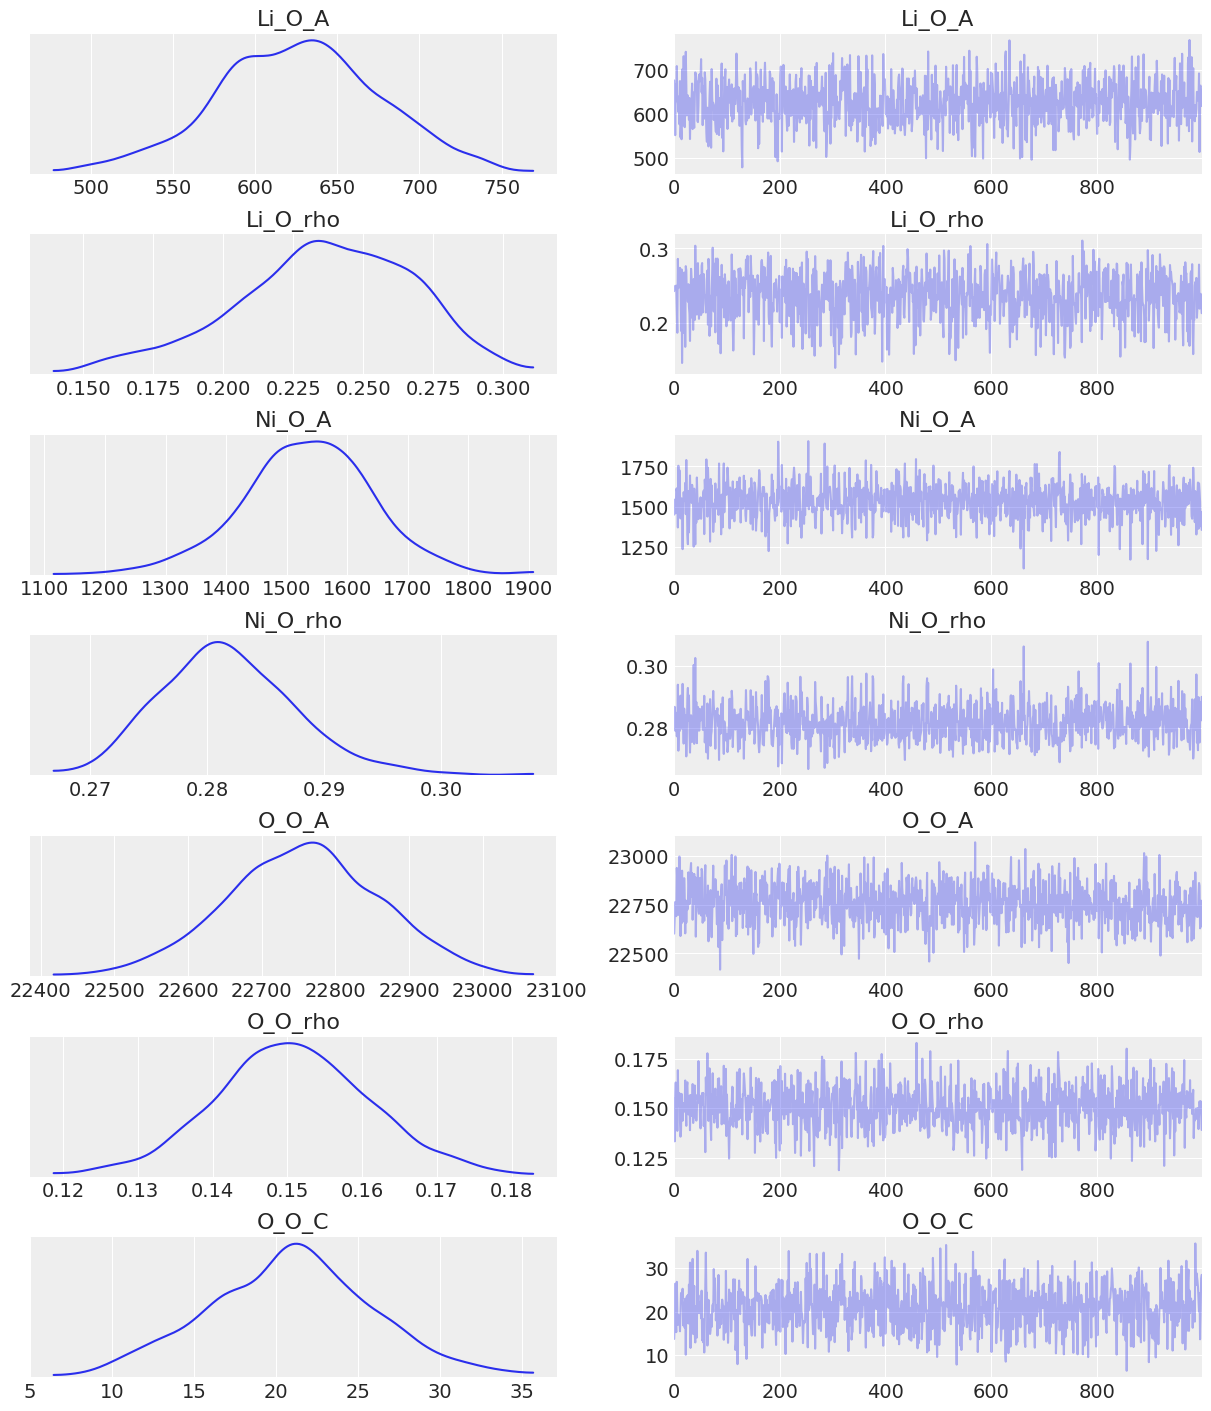

In [10]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)
plt.savefig('coreshell_LiNiO2_trace2.png',dpi=500, bbox_inches = "tight")

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


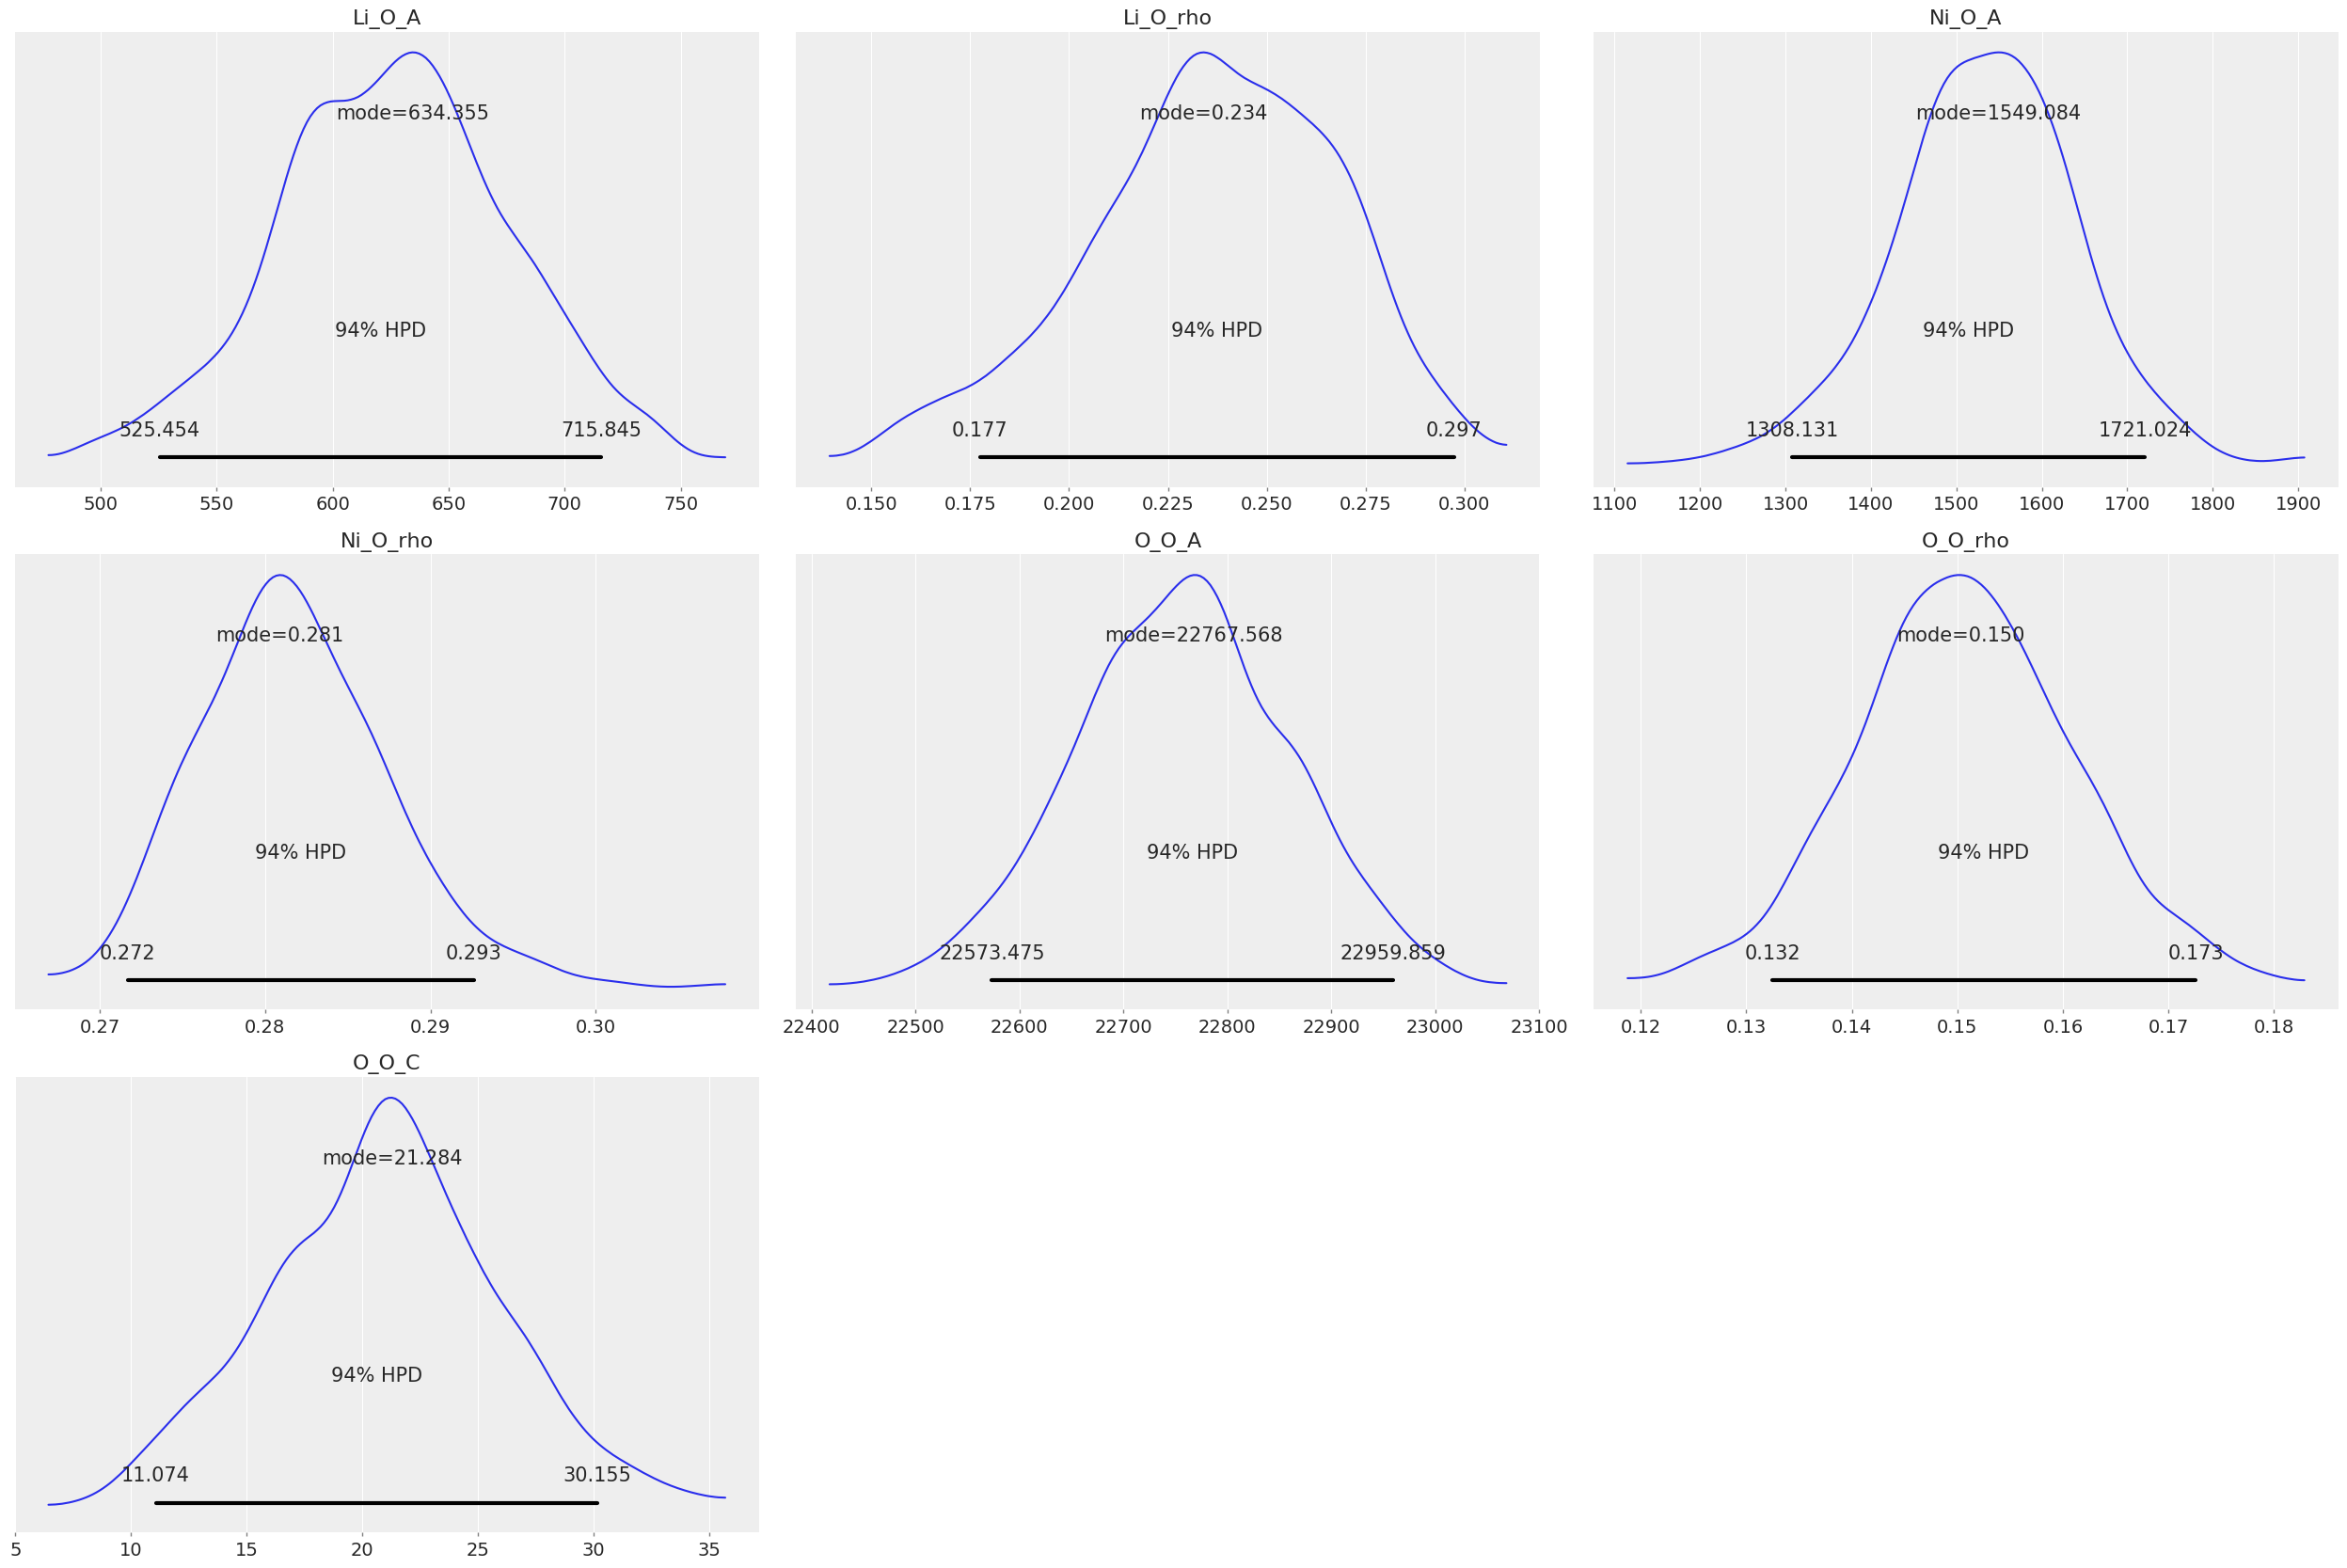

In [11]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')
plt.savefig('coreshell_LiNiO2_mode2.png',dpi=500, bbox_inches = "tight")